## Keras AutoTuner for Hyperparameters

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
!pip install -q -U keras-tuner
import kerastuner as kt

     |████████████████████████████████| 71kB 3.6MB/s 


## GPU Setup

In [ ]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("GPUs Available: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

GPUs Available:  1


## Load the Fashion MNIST dataset

In [ ]:
(img_train, label_train), (img_test, label_test) = keras.datasets.fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


## Show samples from the dataset

In [ ]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

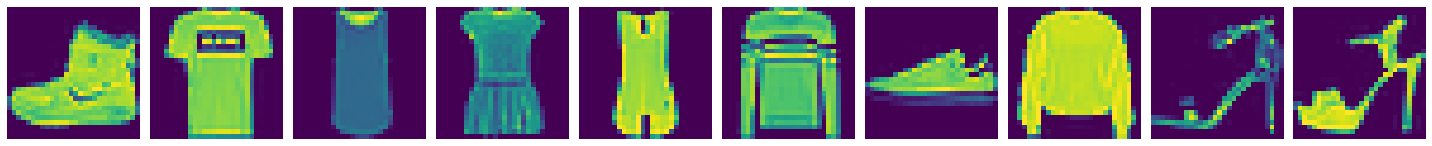

In [ ]:
plotImages(img_train[:10])

## Build the Model

In [ ]:
def model_builder(hp):
  model = keras.Sequential()
  model.add(keras.layers.Flatten(input_shape=(28, 28)))

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
  model.add(keras.layers.Dense(units=hp_units, activation='relu'))
  model.add(keras.layers.Dense(10))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

  return model

## Instantiate the tuner and perfrom hypertuning

In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt')

In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

In [ ]:
tuner.search(img_train, label_train, epochs=20, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

Trial 30 Complete [00h 00m 38s]
val_accuracy: 0.7456666827201843

Best val_accuracy So Far: 0.8488333225250244
Total elapsed time: 00h 08m 02s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 384 and the optimal learning rate for the optimizer
is 0.0001.



## Train the Model

In [ ]:
# Build the model with the optimal hyperparameters and train it on the data for 30 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(img_train, label_train, epochs=30, validation_split=0.2)


Epoch 1/30
1500/1500 [==============================] - 5s 3ms/step - loss: 20.9784 - accuracy: 0.6681 - val_loss: 6.6482 - val_accuracy: 0.7839
Epoch 2/30
1500/1500 [==============================] - 4s 3ms/step - loss: 5.0858 - accuracy: 0.8112 - val_loss: 6.2541 - val_accuracy: 0.7637
Epoch 3/30
1500/1500 [==============================] - 4s 3ms/step - loss: 3.7666 - accuracy: 0.8259 - val_loss: 3.4483 - val_accuracy: 0.8320
Epoch 4/30
1500/1500 [==============================] - 4s 3ms/step - loss: 2.8215 - accuracy: 0.8383 - val_loss: 2.5204 - val_accuracy: 0.8442
Epoch 5/30
1500/1500 [==============================] - 4s 3ms/step - loss: 2.2440 - accuracy: 0.8461 - val_loss: 2.9213 - val_accuracy: 0.8235
Epoch 6/30
1500/1500 [==============================] - 4s 3ms/step - loss: 1.8705 - accuracy: 0.8567 - val_loss: 2.2525 - val_accuracy: 0.8411
Epoch 7/30
1500/1500 [==============================] - 4s 3ms/step - loss: 1.4950 - accuracy: 0.8632 - val_loss: 2.2710 - val_accuracy

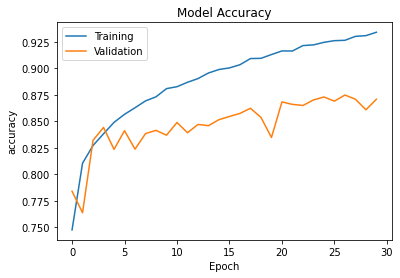

In [ ]:
# Plot the accuracy of the model during training
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

## Evaluate the Trained Model

In [ ]:
evaluation = model.evaluate(img_test, label_test)
print("[test loss, test accuracy]:", evaluation)

313/313 [==============================] - 1s 3ms/step - loss: 0.7926 - accuracy: 0.8690
[test loss, test accuracy]: [0.7926274538040161, 0.8690000176429749]


## Predictions

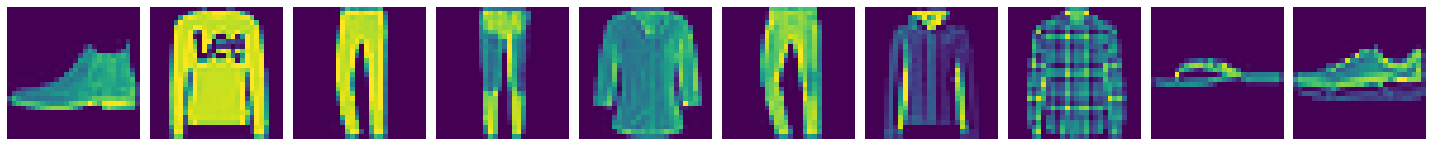

In [ ]:
plotImages(img_test[:10])

In [ ]:
predictions = np.argmax(model.predict(img_test[:10]), axis=-1)
print(predictions)

[9 2 1 1 6 1 4 6 5 7]
